In [1]:
import numpy as np
import matplotlib
from tqdm import tqdm
import scipy as sp
import sympy as smp
import matplotlib.pyplot as plt
from scipy.misc import derivative
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

def opt_plot():
    plt.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = 15
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Scipy

Software versions
Python 3.9.2 64bit [MSC v.1928 64 bit (AMD64)]
IPython 7.25.0
OS Windows 10 10.0.19041 SP0
Matplotlib 3.4.2
Numpy 1.26.1
Scipy 1.11.3
Mon Mar 18 23:28:02 2024 Hora oficial do Brasil

In [3]:
# Discretização espacial
dx = 20
dz = dx
nx = 400
nz = 400
# Posição xz da fonte
ixs = 200
izs = 200
# Posição xz do receptor
izr = 200
ixr = 100
# Discretização temporal
nt = 350 # Nt*dt is the time duration of the propagation
dt = 0.005  # sampling period in time (seconds)
snap1 = 50  # time of the first snapshot = snap1*dt
snapRate = 50  # time between snapshots = snapRate*dt

# Parâmetros do meio homogêneo
rho = 1
cp = 1500
cs = 500

# Coeficiente da aproximação de segunda ordem para a derivada
g1 = -1.0 / 24.0
g2 = 9.0 / 8.0
soufac = dt / (dx * dx)
bb = dt / dx * (1.0 / rho)
rlamu = cp * cp * rho * dt / dx
rmu = cs * cs * rho * dt / dx
rla = rlamu - (2.0 * rmu)

# Inicializando a grade
x = np.arange(nx)
rx = x * dx    # Coordenada x
z = np.arange(nz)
rz = z * dz   # Coordenada z

time = np.linspace(0 * dt, nt * dt, nt)

# Definindo componentes da solução numérica
G0 = 1
F0 = G0
a = 100
beta = cp**2
xx = abs(ixr - ixs)*dx
zz = abs(izr - izs)*dz
rr = np.sqrt(xx**2 + zz**2)

In [4]:
def fb2(k,t,a,beta,r):
    return np.exp(-0.25 * a**2 * k**2)*np.cos(k*t*np.sqrt(beta))*k**2*sp.special.jn(1,k*r)

def fdb2(k,t,a,beta,r):
    return np.exp(-0.25 * a**2 * k**2)*np.cos(k*t*np.sqrt(beta))*0.5*k**3*(sp.special.jn(0, k*r) - sp.special.jn(2, k*r))

In [5]:
# Analitical solution to G0 = F0
dxux = np.zeros(nt)
dzuz = np.zeros(nt)

k = np.linspace(0,90,100000)

for i in range(nt):
    
    # Evolueting numerical integrals
    b2 = sp.integrate.trapz(fb2(k,time[i],a,beta,rr), k)
    db2 = sp.integrate.trapz(fdb2(k,time[i],a,beta,rr), k)
    
    # Compute components of strain tensor
    dxux[i] = ( 
                -0.5*a**2*((1./rr) - (xx**2)/rr**3)*b2 - 0.5*a**2*(xx**2/ rr**2)*db2
              )
    
    dzuz[i] = ( 
                -0.5*a**2*((1./rr) - (zz**2)/rr**3)*b2 - 0.5*a**2*(zz**2/ rr**2)*db2
              )
    
# Compute component txx of tensor
txxAna = rlamu * dxux + rla * dzuz

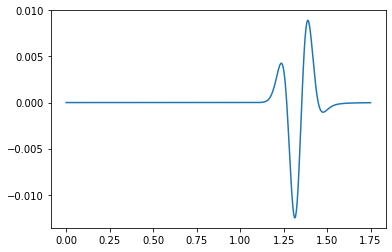

In [6]:
plt.plot(time, txxAna)
plt.show()

In [7]:
x, z, F0, G0, a, l, mu = smp.symbols('x z F0 G0 a l mu', real=True)
ux0 = -F0*(2*x/a**2)*smp.exp(-(x**2 + z**2)/a**2)
uz0 = -G0*(2*z/a**2)*smp.exp(-(x**2 + z**2)/a**2)
dux2 = (l + 2*mu)*smp.diff(ux0, x) + l*smp.diff(uz0, z)
duz2 = (l + 2*mu)*smp.diff(uz0, z) + l*smp.diff(ux0, x)
duxz2 = mu*0.5*(smp.diff(uz0, x) + smp.diff(ux0, z))

In [8]:
duxz2

0.5*mu*(4*F0*x*z*exp((-x**2 - z**2)/a**2)/a**4 + 4*G0*x*z*exp((-x**2 - z**2)/a**2)/a**4)

In [9]:
txxrec = np.zeros(nt)
vx = np.zeros((nz, nx))
vz = np.zeros((nz, nx))
txx = np.zeros((nz, nx))
tzz = np.zeros((nz, nx))
txz = np.zeros((nz, nx))

snapTimes = np.arange(snap1, nt, snapRate)

pSnap = np.zeros((nz, nx, len(snapTimes)))
vxSnap = np.zeros((nz, nx, len(snapTimes)))
vzSnap = np.zeros((nz, nx, len(snapTimes)))

sx, sz = np.meshgrid(rx - rx[ixs], rz - rz[izs])

# Condição Inicial
fx0 = smp.lambdify((x,z,F0,G0,a,l,mu), dux2)
fz0 = smp.lambdify((x,z,F0,G0,a,l,mu), duz2)
fxz0 = smp.lambdify((x,z,F0,G0,a,l,mu), duxz2)
txx0 = fx0(x=sx,z=sz ,F0=1, G0=1, a=100, l=rla, mu=rmu)
tzz0 = fz0(x=sx,z=sz, F0=1, G0=1, a=100, l=rla, mu=rmu)
txz0 = fxz0(x=sx,z=sz, F0=1, G0=1, a=100, l=rla, mu=rmu)

In [10]:
txx += txx0
tzz += tzz0
txz += txz0

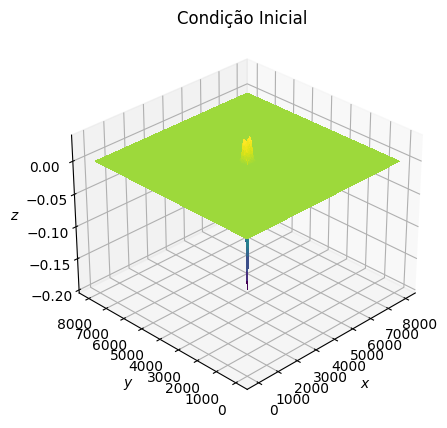

In [11]:
def plot2D_nolim(x, y, p):
    fig = plt.figure(figsize=(10, 5), dpi=100)
    ax = fig.add_subplot(projection='3d')
    X, Y = np.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, p[:], rstride=1, cstride=1, cmap='viridis',
            linewidth=0, antialiased=False)
    ax.view_init(30, 225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.set_title('Condição Inicial')
    
plot2D_nolim(rx, rz, txx)

In [12]:
# Create meshgrid indices for vectorized operations
i, k = np.meshgrid(np.arange(2, nz - 2), np.arange(2, nx - 2), indexing='ij')

if (cp*dt)/dx <= 1/(abs(g1) + abs(g2)):
    print('Status : Stability critrerium obeyed')

    with tqdm(total=nt) as progressing_load:
        for c1 in range(nt):
                           
            #Atualizando o campo de velocidade

            vx[i, k] = vx[i, k] + bb * (
                g1 * (txx[i + 1, k] - txx[i - 2, k]) + g2 * (txx[i, k] - txx[i - 1, k]) +
                g1 * (txz[i, k + 2] - txz[i, k - 1]) + g2 * (txz[i, k + 1] - txz[i, k]))

            vz[i, k] = vz[i, k] + bb * (
                g1 * (txz[i + 2, k] - txz[i - 1, k]) + g2 * (txz[i + 1, k] - txz[i, k]) +
                g1 * (tzz[i, k + 1] - tzz[i, k - 2]) + g2 * (tzz[i, k] - tzz[i, k - 1]))
                
            # Atauliazando o campo de tensão

            exx = g1 * (vx[i + 2, k] - vx[i - 1, k]) + g2 * (vx[i + 1, k] - vx[i, k])
            ezz = g1 * (vz[i, k + 2] - vz[i, k - 1]) + g2 * (vz[i, k + 1] - vz[i, k])
            exz = g1 * (vx[i, k + 1] - vx[i, k - 2]) + g2 * (vx[i, k] - vx[i, k - 1]) + g1 * (vz[i + 1, k] - vz[i - 2, k]) + g2 * (vz[i, k] - vz[i - 1, k])

            txx[i, k] = txx[i, k] + rlamu * exx + rla * ezz
            tzz[i, k] = tzz[i, k] + rla * exx + rlamu * ezz
            txz[i, k] = txz[i, k] + rmu * exz
            
            txxrec[c1] = txx[izr, ixr]
                
            # Guardando frames do campo de pressão e velocidade

            if c1 in snapTimes:
                snapIdx = np.where(snapTimes == c1)[0][0]
                pSnap[:, :, snapIdx] = 0.5 * (txx[0:nz, 0:nx] + tzz[0:nz, 0:nx])
                vxSnap[:, :, snapIdx] = vx[0:nz, 0:nx]
                vzSnap[:, :, snapIdx] = vz[0:nz, 0:nx]
            
            txx[izs, ixs] = 0.0

            progressing_load.update(1)
else:
    print('Status : Criterium stability not obeyed')

Status : Stability critrerium obeyed


100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [00:48<00:00,  7.25it/s]


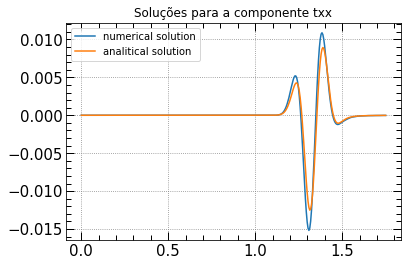

In [13]:
plt.title('Soluções para a componente txx')
plt.plot(time, txxrec*2, label='numerical solution')
plt.plot(time, txxAna, label='analitical solution')
plt.legend()
opt_plot()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


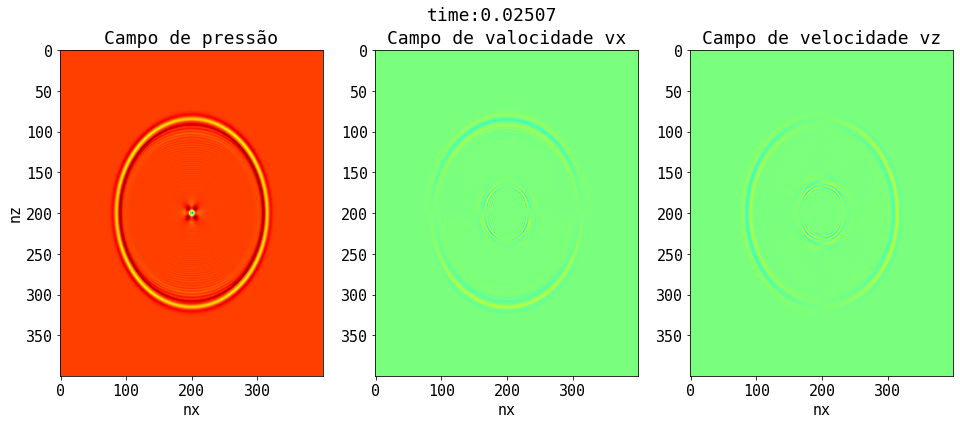

In [14]:
fig, ax = plt.subplots(1,3, figsize = (16, 6))

ax[0].set_title('Campo de pressão')
ax[1].set_title('Campo de valocidade vx')
ax[2].set_title('Campo de velocidade vz')

ax[0].set_xlabel('nx')
ax[0].set_ylabel('nz')
ax[1].set_xlabel('nx')
ax[2].set_xlabel('nx')

def update(i):
    plt.suptitle(f'time:{round(time[i],5)}')
    ax[0].imshow(pSnap[:, :, i], aspect='auto', origin='upper', cmap='jet', clim=(np.min(pSnap[:,:,4]), np.max(pSnap[:,:,4])))
    ax[1].imshow(vxSnap[:, :, i], aspect='auto', origin='upper', cmap='jet', clim=(np.min(vxSnap[:,:,1]), np.max(vxSnap[:,:,1])))
    ax[2].imshow(vzSnap[:, :, i], aspect='auto', origin='upper', cmap='jet', clim=(np.min(vzSnap[:,:,1]), np.max(vzSnap[:,:,1])))
    
ani = animation.FuncAnimation(fig, update, pSnap.shape[2] , interval = 130, repeat = True, cache_frame_data = False)
ani.save(f'GaussianaPulse.gif')
plt.show()